In [ ]:
!pip install wfdb

In [ ]:

# Import necessary modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
# Import EarlyStopping directly from tensorflow.keras.callbacks
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report, f1_score
import wfdb
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load a single record (e.g., record 100)
record = wfdb.rdrecord('/content/drive/MyDrive/DL-Project/Data/mit-bih-arrhythmia-database-1.0.0/100')
annotation = wfdb.rdann('/content/drive/MyDrive/DL-Project/Data/mit-bih-arrhythmia-database-1.0.0/100', 'atr')

# Extract signals and annotations
signals = record.p_signal  # ECG signals (2 channels)
fs = record.fs  # Sampling frequency
annotations = annotation.sample  # Annotation positions in samples
labels = annotation.symbol  # Annotation symbols

In [ ]:
from scipy.signal import butter, filtfilt

def highpass_filter(signal, cutoff=0.5, fs=360, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

filtered_signal = highpass_filter(signals[:, 0])  # Apply to channel 1

In [ ]:
normalized_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)

In [ ]:
def extract_segments(signals, annotations, labels, fs, segment_duration=2):
    segments = []
    segment_labels = []
    segment_length = segment_duration * fs // 2

    for i, idx in enumerate(annotations):
        start = max(0, idx - segment_length)
        end = min(len(signals), idx + segment_length)
        segment = signals[start:end]

        # Pad if the segment is shorter than desired length
        if len(segment) < 2 * segment_length:
            segment = np.pad(segment, (0, 2 * segment_length - len(segment)), 'constant')

        segments.append(segment)
        segment_labels.append(labels[i])

    return np.array(segments), np.array(segment_labels)

segments, segment_labels = extract_segments(normalized_signal, annotations, labels, fs)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(segment_labels)

# Check label mapping
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'+': 0, 'A': 1, 'N': 2, 'V': 3}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 568.5, 1: 17.227272727272727, 2: 0.2539079946404645, 3: 568.5}


In [ ]:
import os
import wfdb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt, iirnotch

# Define preprocessing functions

# 1. High-pass filter to remove baseline wander
def highpass_filter(signal, cutoff=0.5, fs=360, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# 2. Notch filter to remove power-line interference
def notch_filter(signal, freq=50, fs=360, Q=30):
    w0 = freq / (fs / 2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, signal)

# 3. Normalize the signal
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# 4. Process a single record file
def process_record(file_path, segment_duration=2, fs=360):
    # Load the signal and annotations
    record = wfdb.rdrecord(file_path)
    annotation = wfdb.rdann(file_path, 'atr')

    # Extract signals and annotations
    signals = record.p_signal[:, 0]  # Use channel 0 (e.g., MLII)
    annotations = annotation.sample  # Sample indices of R-peaks
    labels = annotation.symbol  # Labels for each R-peak

    # Preprocess signals: filtering and normalization
    signals = highpass_filter(signals)
    signals = notch_filter(signals)
    signals = normalize_signal(signals)

    # Segment the signals around each R-peak
    segment_length = segment_duration * fs // 2
    segments, segment_labels = [], []

    for i, idx in enumerate(annotations):
        start = max(0, idx - segment_length)
        end = min(len(signals), idx + segment_length)
        segment = signals[start:end]

        # Pad if the segment is shorter than desired length
        if len(segment) < 2 * segment_length:
            segment = np.pad(segment, (0, 2 * segment_length - len(segment)), 'constant')

        segments.append(segment)
        segment_labels.append(labels[i])

    return np.array(segments), np.array(segment_labels)

# Aggregate data from multiple files
def process_multiple_files(data_dir, record_files, segment_duration=2, fs=360):
    all_segments = []
    all_labels = []

    for record in record_files:
        file_path = os.path.join(data_dir, record)
        segments, labels = process_record(file_path, segment_duration, fs)
        all_segments.append(segments)
        all_labels.append(labels)

    # Combine all segments and labels
    X = np.vstack(all_segments)  # Stack all segments into one array
    y = np.concatenate(all_labels)  # Concatenate all labels into one array
    return X, y

# Directory containing the dataset
data_dir = "/content/drive/MyDrive/DL-Project/Data/mit-bih-arrhythmia-database-1.0.0/"

# List of all record files (without extensions)
record_files = [
    "100", "101", "102"
]

# Process all files
X, y = process_multiple_files(data_dir, record_files)

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display label mapping
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape data for RNN input
X_train = X_train[..., np.newaxis]  # Add a channel dimension
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]



print("Preprocessing complete!")
print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}, {y_val.shape}")
print(f"Test Data Shape: {X_test.shape}, {y_test.shape}")


Label Mapping: {'+': 0, '/': 1, 'A': 2, 'N': 3, 'Q': 4, 'V': 5, 'f': 6, '|': 7, '~': 8}
Preprocessing complete!
Training Data Shape: (4438, 720, 1), (4438,)
Validation Data Shape: (951, 720, 1), (951,)
Test Data Shape: (951, 720, 1), (951,)


In [ ]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head Self-Attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward Network
    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dense(inputs.shape[-1])(ff)
    x = layers.Dropout(dropout)(ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    return x

# Build the Transformer Model
def build_transformer_model(input_shape, num_classes, num_heads=4, head_size=64, ff_dim=128, num_transformer_blocks=2, dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    embedding_layer = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])
    embeddings = embedding_layer(positions)
    x = inputs + embeddings

    # Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Pooling and Classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [ ]:
# Function to plot training history
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.show()

In [ ]:
# Get input shape and number of classes
input_shape = X_train.shape[1:]  # (timesteps, features)
num_classes = len(np.unique(y_train))

In [ ]:
# Train and evaluate the model
def train_and_evaluate_transformer(X_train, y_train, X_val, y_val, X_test, y_test):
    # Build the model
    model = build_transformer_model(input_shape, num_classes)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping]
    )

    # Plot training history
    plot_history(history)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predictions and classification report
    y_pred = model.predict(X_test).argmax(axis=1)
    print(classification_report(y_test, y_pred))

    # Weighted F1 Score
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"Weighted F1 Score: {f1:.4f}")

    return model

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.6068 - loss: 2.1699 - val_accuracy: 0.6740 - val_loss: 2.0815
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.6595 - loss: 2.0494 - val_accuracy: 0.6740 - val_loss: 1.9396
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.6590 - loss: 1.9025 - val_accuracy: 0.6740 - val_loss: 1.7761
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.6587 - loss: 1.7389 - val_accuracy: 0.6740 - val_loss: 1.6022
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.6687 - loss: 1.5680 - val_accuracy: 0.6740 - val_loss: 1.4329
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.6675 - loss: 1.4051 - val_accuracy: 0.6740 - val_loss: 1.2791
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.6620 - loss: 1.2624 - val_accuracy: 0.6740 - val_loss: 1.1507
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.6612 - loss: 1.1560 - val_accuracy:

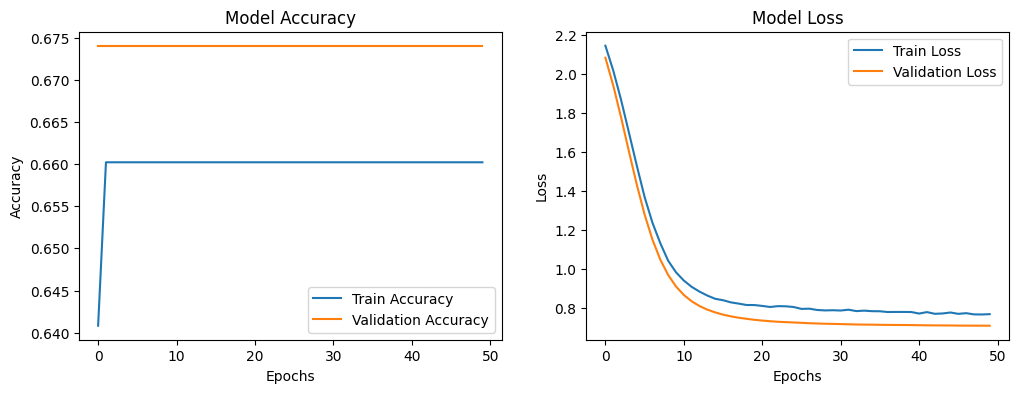

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6437 - loss: 0.7640
Test Accuracy: 0.6593
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       305
           2       0.00      0.00      0.00         9
           3       0.66      1.00      0.79       627
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1

    accuracy                           0.66       951
   macro avg       0.11      0.17      0.13       951
weighted avg       0.43      0.66      0.52       951

Weighted F1 Score: 0.5239


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Train and evaluate the transformer model
transformer_model = train_and_evaluate_transformer(X_train, y_train, X_val, y_val, X_test, y_test)